# Ship roll-decay simulation
> This is a short introduction to how a ship roll-decay test can be simulated.

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [roll-decay,simulation]
- image: https://exitoina.uol.com.br/media/_versions/beatlessss_widelg.jpg
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

In [1]:
#hide
import warnings
warnings.filterwarnings("ignore")

## Roll damping

A systems ability to damp reconance motions can be crucial as in the case of the Tacoma-narrows-bridge-collapse:
![](https://upload.wikimedia.org/wikipedia/commons/4/4a/Tacoma-narrows-bridge-collapse.jpg)

Resonance phenomena can also occur for ships, where for instance something called parametric roll can happen as can be seen in this video:

<iframe width="560" height="315" src="https://www.youtube.com/embed/7PyJj_oPdyg?start=29" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

Having enough roll damping is one way to deal with this problem.

## Ship roll-decay test
One way to determine the roll damping is to conduct a so called Roll-decay test. This test is conducted by giving the ship an initial roll angle and then observing the resulting oscillation. The oscillation motion will decrease with time due to energy losses from friction with the water and other things such as wave and eddy generation. Here is an example of a roll decay model test:

<iframe width="560" height="315" src="https://www.youtube.com/embed/gN123b8gM-o" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [2]:
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interactive

## Simulation
Newtons 2nd law can be used to predict the resulting motion from forces:
$$F=m \cdot a$$
so we want to determine acceleration $a$ which can then be integrated to get the velocity and position to describe the motion.

In [3]:
def calculate_acceleration(F,m):
    a = F/m
    return a

Lets simulate a 1 kg object falling without any drag. 
It can be done by:
1. calculate acceleration
2. calculate the velocity by adding acceleration
3. calculate the position by adding the velocity

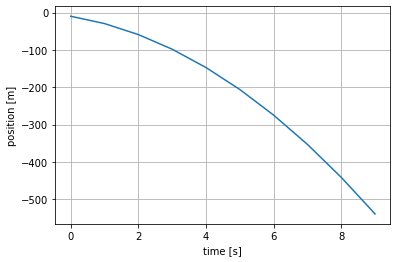

In [4]:
dt = 1.0
t = np.arange(0,10,dt)

g=9.81
F=-g
m=1
velocity=0.0  # initial velocity
position=0.0  # initial position
positions=[]
for n in range(len(t)):
    
    acceleration = calculate_acceleration(F=F, m=m)
    velocity = velocity + acceleration*dt
    position = position + velocity*dt
    positions.append(position)
    
fig,ax=plt.subplots()
ax.plot(t,positions);
ax.set_xlabel('time [s]')
ax.set_ylabel('position [m]');
ax.grid(True)

In [5]:
#collapse
dt = 0.5
t = np.arange(dt,10,dt)

g=9.81
F=-g
m=1
velocity=0.0  # initial velocity
position=0.0  # initial position
t_old = 0

def update(t=0.0):
    
    global velocity
    global position
    global t_old
    
    dt = t-t_old
    t_old = t
    
    acceleration = calculate_acceleration(F=F, m=m)
    velocity = velocity + acceleration*dt
    position = position + velocity*dt
    
    fig,ax=plt.subplots()
    ax.plot([0],[position],'bo',ms=20)
    ax.set_ylim(-600,0)
    ax.set_xlim(0,0)
    
interactive_plot = interactive(update, t=(t[0], t[-1], dt))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.5, description='t', max=9.5, min=0.5, step=0.5), Output(layout=Layou…

$$
A\cdot\ddot{\phi} + B\cdot\dot{\phi} + C\cdot\phi = 0
$$